In [1]:
import numpy as np
import cmath
import matplotlib.pyplot as plt

${\boldsymbol x}_k \in {\mathbb R}^{M\times 1}$  ${\boldsymbol x}_{k,m} \in \{ 0,1\}$


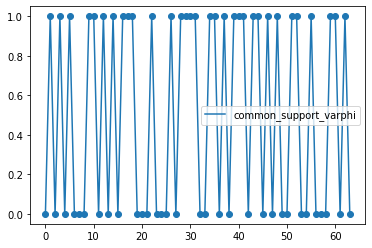

In [2]:
## generate channel support
K=4
p01 = 0.5
p10 = 0.5
M = 64
tau = 8
# 6 is a nice value
np.random.seed(2)
def common_channel_support(p01 = 0.1, p10=0.3, M= 64):
    p0 = p10/(p10+p01)
    p1 = 1-p0

    # generate Markov chain
    tmp_support = np.array([0.0 for m in range(M)])
    if np.random.uniform(0,1,1)[0] < p0:
        tmp_support[0] = 0
    for i in range(M - 1):
        if tmp_support[i] == 0:
            if np.random.uniform(0,1,2)[0] < p01:
                tmp_support[i+1] = 1
            else:
                tmp_support[i+1] = 0
        else:
            if np.random.uniform(0,1,2)[1] < p10:
                tmp_support[i+1] = 0
            else:
                tmp_support[i+1] = 1
    return tmp_support

common_support_varphi = common_channel_support(p01, p10, M)
plt.scatter(range(M), common_support_varphi)
plt.plot(range(M), common_support_varphi)
plt.legend(['common_support_varphi'])


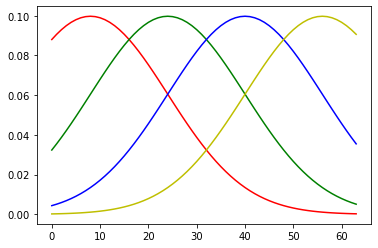

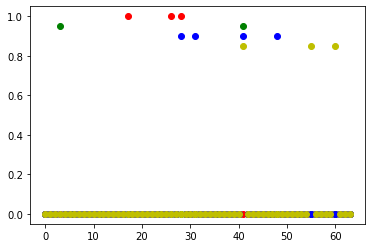

In [3]:
np.random.seed(3)
color_list = ['r', 'g', 'b', 'y']
sigma = 4
less_likely_to_appear = 5


# generate individual AoAs support
def pdf_for_all_user(user_index, K = 4, M = 64, sigma = 6):
    x = np.linspace(0,M-1,M)
    mu = int(user_index*(M/K)+0.5*M/K)
    return 1/(np.power(2*np.pi*np.power(sigma,2), 0.5)) * np.exp(-0.5 * np.power((x-mu)/np.power(sigma,2),2))

conditinal_pdf_list = [pdf_for_all_user(k,K,M,sigma=sigma) for k in range(K)]
for k in range(K):
    plt.plot(range(M), conditinal_pdf_list[k], color_list[k])

# initialization for all users' channel support
channel_support_for_all_users = np.array([[0 for m in range(M)] for k in range(K)] )

for k in range(K):
    for m in range(M):
        if common_support_varphi[m] == 1:
            maxi = np.max(conditinal_pdf_list[k])*less_likely_to_appear
            if np.random.uniform(0,maxi,K*M)[m+k*m] < conditinal_pdf_list[k][m]:
                channel_support_for_all_users[k][m] = 1
            else:
                channel_support_for_all_users[k][m] = 0

plt.figure(2)
for k in range(K):
    plt.scatter(np.array(range(M)), channel_support_for_all_users[k] * (1-0.05*k), color=color_list[k])
    # plt.plot(np.array(range(M)), channel_support_for_all_users[k] * (k+1)/K, color=color_list[k])



$\varphi_{k,j} = \frac{d}{\lambda}\operatorname{cos}(\varphi_{\theta}) \in [-0.5, 0.5)$

$$
\mathbf{a}_{X}(x)=\left[1, e^{-\mathrm{i} 2 \pi x}, \ldots, e^{-\mathrm{i} 2 \pi(X-1) x}\right]^{\mathrm{T}}
$$

$\Delta \varphi_{k,j}=\varphi_{k,j} -\varphi_{k,j}^g \in [0,\frac{1}{M})$

$$
\psi_l^g = 
\begin{cases}
\frac{n_l-1}{N}\quad &,\frac{n_l-1}{N} < 0.5 \\
\frac{n_l-1}{N}-1 &, \frac{n_l-1}{N}\geq 0.5
\end{cases}
$$

$\mathbf{a}_{M,k}^{D F T}(\boldsymbol{\varphi})=\mathbf{D}_{M}(\Delta \boldsymbol{\varphi}) \boldsymbol{x}_k = \sum_{j}^{J_k} \beta_{k,j} {\mathbf a}_M(\varphi_{k,j})$

[[<matplotlib.lines.Line2D at 0xa164ee0>],

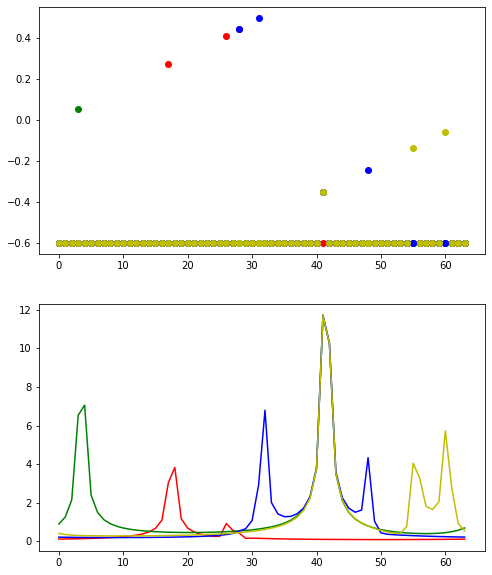

In [4]:
def array_response(M, x):
    m = np.linspace(0, M-1, M)
    return np.exp(1j*2*np.pi*m*x)


def DFT_matrix(M):
    return np.power(M,-0.5)*np.mat(np.fft.fft(np.eye(M)))


np.random.seed(3)
Delta_varphi_min = 0
Delta_varphi_max = 1/M
Delta_varphi = np.random.uniform(Delta_varphi_min, Delta_varphi_max, M)
Varphi_grid = np.array([m/M if m/M < 0.5 else m/M - 1 for m in range(M)])

Varphi_true = [[] for k in range(K)]
for k in range(K):
    for m in range(M):
        if channel_support_for_all_users[k][m] == 1:
            Varphi_true[k].append(Delta_varphi[m] + Varphi_grid[m])
        else:
            Varphi_true[k].append(-0.6)

plt.figure(figsize=(8,10))
plt.subplot(2,1,1)
[plt.scatter(range(M), Varphi_true[k], color = color_list[k]) for k in range(K)]

Beta_true = np.random.normal(0, 1, M)

a_M_k = np.array([[np.complex128(0) for m in range(M)] for k in range(K)])
for k in range(K):
    sum_tmp = np.array([np.complex128(0) for m in range(M)])
    for m, varphi in enumerate(Varphi_true[k]):
        if varphi != -0.6:
            sum_tmp = sum_tmp + Beta_true[m] * array_response(M, varphi)
    a_M_k[k] = sum_tmp

DFT_M = DFT_matrix(M)
a_M_k_DFT = [DFT_M * np.mat(np.reshape(a_M_k[k], (M,-1))) for k in range(K)]

plt.subplot(2,1,2)
[plt.plot(range(M), np.abs(a_M_k_DFT[k]), color_list[k]) for k in range(K)]
# plt.plot(range(M), np.abs(a_M_k_DFT[1]), color_list[1])
# plt.figure(5)
# plt.plot(range(M), np.abs(DFT_M * np.reshape(np.mat(array_response(M, 0.4)), (M,-1))))

${\mathbf D}_M(\Delta {\boldsymbol \varphi})= [D_M(\Delta \varphi_1),\dots,D_M(\Delta \varphi_M)] \in {\mathbb C}^{M\times M}$

$$
D_M(\Delta {\varphi_1},m^{\prime})=\begin{cases}
\begin{aligned}
f_M({2\pi}(\frac{m^{\prime}-m} {M} - 1+\Delta\varphi))\ &, \frac{m^{\prime}-1}{M} < 0.5 \\
f_M({2\pi}(\frac{m^{\prime}-m} {M}+\Delta\varphi)) &, \frac{m^{\prime}-1}{M} \geq 0.5
\end{aligned}

\end{cases}
$$
$$
f_M(x) = \frac{1}{\sqrt{M}}e^{jx(M-1)/2} \frac{\operatorname{sin}(Mx/2)}{\operatorname{sin}(x/2)}
$$


[[<matplotlib.lines.Line2D at 0xa245c70>],

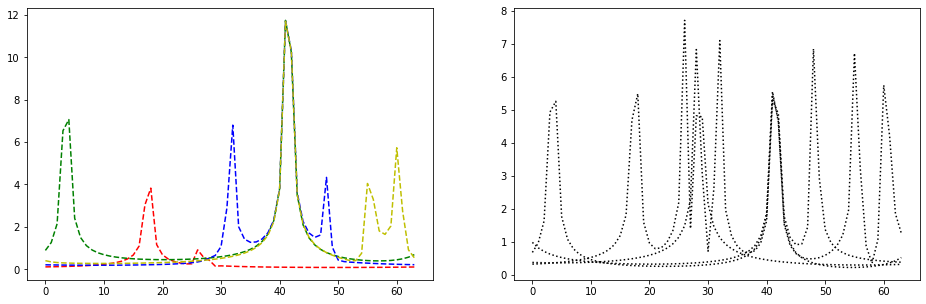

In [5]:
## generate D_M
def f_N(N, x):
    if abs(x) == 0:
        return N
    else:
        return 1/np.sqrt(N)*cmath.exp(1j*x*(N-1)/2)*(cmath.sin((N)*x/2))/(cmath.sin(x/2))

def generate_DM(M, Delta_varphi):
    DM = np.matrix([np.complex128(0) for m in range(M * M)]).reshape((M,M))
    for col in range(M):
        if col/float(M) < 0.5:
            DM[:,col] = np.array([(f_N(M, 2*np.pi *(m/M - col/M - Delta_varphi[col]) )) for m in range(M)]).reshape(M,1)
        else:
            DM[:,col] = np.array([(f_N(M, 2*np.pi *(m/M - col/M + 1 - Delta_varphi[col]) )) for m in range(M)]).reshape(M,1)
    return DM

DM_varphi = generate_DM(M, Delta_varphi)

DM_mul_x_K = [DM_varphi * np.reshape(np.mat(channel_support_for_all_users[k]), (M,1)) for k in range(K)]

plt.figure(figsize=(16, 5))
plt.subplot(1,2,1)
[plt.plot(range(M), np.abs(a_M_k_DFT[k]), color_list[k],linestyle='dashed') for k in range(K)]
plt.subplot(1,2,2)
[plt.plot(range(M), np.abs(DM_mul_x_K[k]), linestyle='dotted', color='black') for k in range(K)]



${\mathbf \Phi}^H \in {\mathbb C}^{\tau \times M}$

${\mathbf V}({\omega_l}) = \operatorname{Diag}({\mathbf{a}_M({\omega_l})}) {\mathbf U}_M^H$

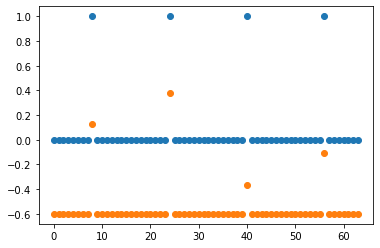

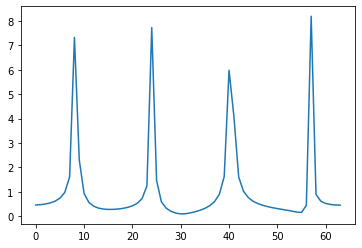

In [6]:
np.random.seed(4)

Omega_support = np.array([1 if (m+M/8) % int(M/4) == 0 else 0 for m in range(M)])
plt.scatter(range(M), Omega_support)

Delta_omega_min = 0
Delta_omega_max = 1/M
Delta_omega = np.random.uniform(Delta_varphi_min, Delta_varphi_max, M)
Omega_grid = np.array([m/M if m/M < 0.5 else m/M - 1 for m in range(M)])

Omega_true = []
for m in range(M):
    if Omega_support[m] == 1:
        Omega_true.append(Delta_omega[m] + Omega_grid[m])
    else:
        Omega_true.append(-0.6)

plt.scatter(range(M),Omega_true)

a_M = np.array([np.complex128(0) for m in range(M)])
for m in range(M):
    if Omega_support[m] == 1:
        a_M = a_M + array_response(M, Omega_true[m])
a_M_DFT = DFT_matrix(M) * np.reshape(np.mat(a_M), (M,1))

plt.figure(6)
plt.plot(range(M), np.abs(a_M_DFT))

# generate V(omega_l)
# def generate_V_wl(M,omega):
#     return np.diag(array_response(M,omega))*DFT_matrix(M).H
def generate_V_wl(M,omega):
    tmp = np.mat([[np.complex128(0) for m in range(M)] for m in range(M)])
    a_M = array_response(M, omega)
    for m in range(M):
        tmp[m,m] = a_M[m]
    return tmp*DFT_matrix(M).H

def generate_Phi_H(M, tau, mode = 'fixed'):
    if mode == 'fixed':
        return np.mat([[np.complex128(1) for m in range(M)] for t in range(tau)])
    elif mode == 'random':
        x = np.random.randint(0,2,(tau, M))
        return np.mat(np.exp(1j*np.pi*x))

Phi_H = generate_Phi_H(M, tau=tau, mode='random')


$${\boldsymbol y}_{l,k} = {\mathbf \Phi}^H {\mathbf V}({\omega_l}){\mathbf D}_M({\Delta}{\boldsymbol \varphi}_k) {\boldsymbol x}_k
+ {\mathbf N}_l ,\forall l \in \{1,\dots,L\}$$

${\boldsymbol x}_k$ $\Longrightarrow$ channel_support_for_all_users[k] <np.array>

${\mathbf D}_M(\Delta {\boldsymbol \varphi})$ $\Longrightarrow$ DM_varphi = generate_DM(M, Delta_varphi) <np.matrix>

${\mathbf V}(\omega_l) $ $\Longrightarrow$ generate_V_wl(M,omega) <np.matrix>

${\mathbf \Phi}^H $ $\Longrightarrow $ generate_Phi_H(M, tau, mode = 'fixed') <np.matrix>

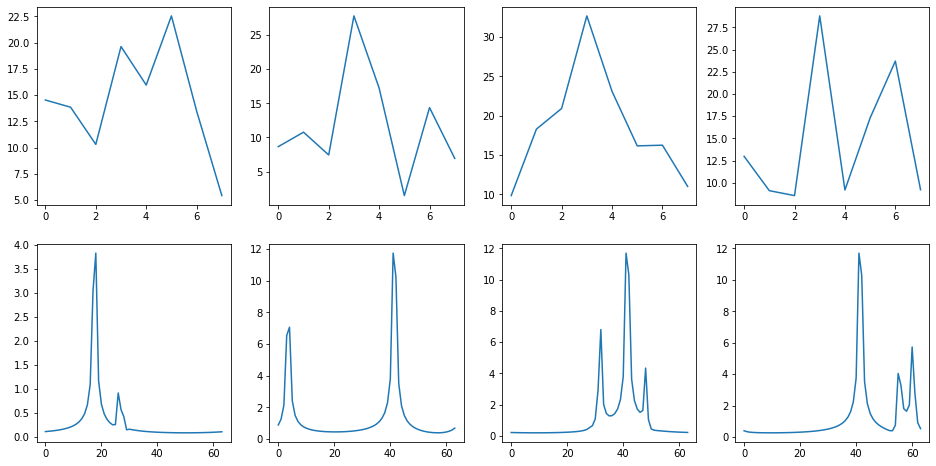

In [7]:
# generate 2D object list P_lk
def generate_P(M, K, Phi_H, Delta_omega, Omega_support, Delta_varphi, channel_support_for_all_users):
    Omega_grid = Varphi_grid = np.array([m/M if m/M < 0.5 else m/M - 1 for m in range(M)])
    P = []
    for m, s_omega in enumerate(Omega_support):
        if s_omega != 1:
            continue
        P_l_tmp = []

        for k in range(K):
            P_lk = Phi_H * generate_V_wl(M, Omega_grid[m] + Delta_omega[m]) * generate_DM(M, Delta_varphi) * np.reshape(np.mat(channel_support_for_all_users[k]), (M, 1))
            P_l_tmp.append(P_lk)
        P.append(P_l_tmp)
    
    return P

P = generate_P( M, K, 
                Phi_H=Phi_H, 
                Delta_omega=Delta_omega, 
                Omega_support=Omega_support, 
                Delta_varphi=Delta_varphi, 
                channel_support_for_all_users=channel_support_for_all_users)


plt.figure(figsize=(16,8))
for k in range(K):
    plt.subplot(2,K,k+1)
    plt.plot(np.abs(P[0][k]))
    plt.subplot(2,K,K+k+1)
    plt.plot(range(M), np.abs(a_M_k_DFT[k]))




# M-step

原问题：
$${\boldsymbol y}_{l,k} = {\mathbf \Phi}^H {\mathbf V}({\omega_l}){\mathbf D}_M({\Delta}{\boldsymbol \varphi}_k) {\boldsymbol x}_k
+ {\mathbf N}_l ,\forall l \in \{1,\dots,L\}$$

首先可以定义该问题中的未知参数${\boldsymbol \xi} \triangleq \{{\boldsymbol \xi}_1,{\boldsymbol \xi}_2,{\boldsymbol \xi}_3 \}$，

${\boldsymbol \xi}_1 = \{\omega_1,\dots,\omega_L \}$

${\boldsymbol \xi}_2=\{\Delta\varphi_1, \dots,\Delta \varphi_M \}$

${\boldsymbol \xi}_3 =\{\lambda^c,p^c_{01}, p^c_{10}, \mu^s_1,\sigma^s_1,\dots, \mu^s_k,\sigma^s_k\}$

${\boldsymbol \xi}$ 更新依据 

$$\boldsymbol{\xi}_{j}^{(i+1)}=\boldsymbol{\xi}_{j}^{(i)}+\left.\gamma^{(i)} \frac{\partial u\left(\boldsymbol{\xi}_{j}, \boldsymbol{\xi}_{-j}^{(i)} ; \boldsymbol{\xi}_{j}^{(i)}, \boldsymbol{\xi}_{-j}^{(i)}\right)}{\partial \boldsymbol{\xi}_{j}}\right|_{\boldsymbol{\xi}_{j}=\boldsymbol{\xi}_{j}^{(i)}}$$

$$u(\boldsymbol{\xi} ; \dot{\boldsymbol{\xi}})=u^{\mathrm{EM}}(\boldsymbol{\xi} ; \dot{\boldsymbol{\xi}})+\sum_{j \in \mathcal{J}_{c}^{1}} \tau_{j}\left\|\boldsymbol{\xi}_{j}-\dot{\boldsymbol{\xi}}_{j}\right\|^{2}$$

$$
\begin{aligned}
u^{\mathrm{EM}}(\boldsymbol{\xi} ; \dot{\boldsymbol{\xi}})&=\int p(\boldsymbol{v} \mid \boldsymbol{p}, \dot{\boldsymbol{\xi}}) \ln \frac{p(\boldsymbol{v}, \boldsymbol{p}, \boldsymbol{\xi})}{p(\boldsymbol{v} \mid \boldsymbol{p}, \dot{\boldsymbol{\xi}})} d \boldsymbol{v} \\
	&\approx \int q(\boldsymbol{v} ; \dot{\boldsymbol{\xi}}) \ln \frac{p(\boldsymbol{v}, \boldsymbol{p}, \boldsymbol{\xi})}{q(\boldsymbol{v} ; \dot{\boldsymbol{\xi}})} d \boldsymbol{v}
	
\end{aligned}
$$

$$
\begin{aligned}
p({\boldsymbol v}, {\boldsymbol y};{\boldsymbol \xi}) & = p({\boldsymbol y}, {\boldsymbol x}, {\boldsymbol \gamma}, {\boldsymbol s}, {\boldsymbol c},{\boldsymbol \kappa})\\
	&=p({\boldsymbol y} | {\boldsymbol x, \boldsymbol \kappa};{\boldsymbol \xi})p({\boldsymbol x} | {\boldsymbol \gamma}) p({\boldsymbol \kappa})p({\boldsymbol \gamma}|{\boldsymbol s})p({\boldsymbol c}, {\boldsymbol s};{\boldsymbol \xi})\\
	&=\underbrace{p({\boldsymbol x} | {\boldsymbol \gamma}) p({\boldsymbol \kappa})p({\boldsymbol \gamma}|{\boldsymbol s})}_{\text{known distribution}} \ \ \underbrace{p({\boldsymbol y} | {\boldsymbol x, \boldsymbol \kappa};{\boldsymbol \xi})p({\boldsymbol c}, {\boldsymbol s};{\boldsymbol \xi})}_{\text{with unknown valuables}}

\end{aligned}
$$

联合概率中的概率表达式可以写为：
$$
\begin{aligned}
p(\boldsymbol{x} \mid \boldsymbol{\gamma})&=\prod_k^K\prod_m^Mp(x_{k,m} \mid \gamma_{k,m})

\end{aligned}
$$

where $p(x_{k,m} \mid \gamma_{k,m})=CN(x_{k,m};0;\gamma_{k,m}^{-1})$

$$
p({\boldsymbol \gamma} \mid {\boldsymbol s}) = \prod_k^K\prod_m^M p(\gamma_{k,m} \mid s_{k,m})
$$

where $p(\gamma_{k,m} \mid s_{k,m})= \Gamma(\gamma_{k,m};a_{k},b_{k})^{s_{k,m}}\Gamma(\gamma_{k,m};\overline{a}_{k},\overline{b}_{k})^{1-s_{k,m}}$

当$s_{k,m}$为1时，$\frac{a_{k}}{b_{k}}=E[\gamma_{k,m}]=PL_{k}^{-1}$,其中$PL_k$为RIS-User k的LoS链路的路损。$\overline{a}_{k,m},\overline{b}_{k,m}$

需要满足：$\frac{\overline{a}_{k,m}}{\overline{b}_{k,m}}=E[\gamma_{k,m}] \gg 1$  

$$p({\boldsymbol y_k \mid {\boldsymbol x}_{k} ; {\boldsymbol \xi}})=CN({\boldsymbol y}_k;{\mathbf F}_k{\boldsymbol x}_k, \operatorname{Diag}({\boldsymbol \kappa}_k)^{-1})$$

$$p({\boldsymbol y} \mid {\boldsymbol x};{\boldsymbol \xi})=\prod_k^Kp({\boldsymbol y_k \mid {\boldsymbol x}_{k} ; {\boldsymbol \xi}})$$

在channel support的底层，我们用common support ${\boldsymbol c}$ 的马尔可夫性质和联合概率 $p({\boldsymbol c},{\boldsymbol s};{\boldsymbol \xi})$ 来刻画channel support的结构化稀疏性[^1-4]：
$$
\begin{aligned}
p({\boldsymbol c}, {\boldsymbol s};{\boldsymbol \xi}) &= p({\boldsymbol c})\prod_{k=1}^Kp({\boldsymbol s}_k \mid {\boldsymbol c}) \\
	&= p(c_1)\prod_{k=1}^Kp({s}_{k,1} \mid c_1) \prod_{m=2}^M\left[ p(c_m \mid c_{m-1} ) \prod_{k=1}^K p(s_{k,m} \mid c_m) \right]
\end{aligned}
$$
为方便起见，我们定义$p_{01}^c \triangleq p(c_m=1\mid c_{m-1}=0),m=\{2,\dots M\}$

$p_{10}^c \triangleq p(c_m=0\mid c_{m-1}=1),m=\{2,\dots M\}$

$$
\begin{aligned}
p_{k}^{s}(m) &=p\left(s_{k, m}=1 \mid c_{m}=1\right) \\
&=\frac{1}{\sqrt{2 \pi} \sigma_{k}^{s}} \exp \left(-\frac{\left(m-\mu_{k}^{s}\right)^{2}}{2 {\sigma_{k}^{s}}^2 }\right)
\end{aligned}
$$


In [8]:
import numpy as np
from scipy import integrate
import sympy
import matplotlib.pyplot as plt

class M_step():
    def __init__(self, E_step):
        self.name = 'default'
        self.E_step = E_step
        self.Xi = 0
        self.count = 0
        pass

    def surrogate_function(self, xi, xi_dot):
        integrate.quad(E_step.q_function)
        return 0
    
    def joint_distribution(self, v, y, xi):

        return 0
    
    def update_Xi(self):

        pass

In [9]:
class E_step():
    def __init__(self):

        pass
    
    def q_function(self, v, xi):

        pass
    